In [1]:
from __future__ import division
from __future__ import print_function
%matplotlib inline
import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator; 
from torcheval.metrics import MulticlassAccuracy, MulticlassConfusionMatrix, MulticlassF1Score
from torch.utils.data import DataLoader, SubsetRandomSampler

from utils import load_data_card
from models import GAT_base, GAT_pos

c:\Users\kaika\anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def createSampler(dataset):
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    np.random.shuffle(dataset_indices)
    split_index = int(np.floor(dataset_size))
    idx = dataset_indices[:split_index]
    return SubsetRandomSampler(idx)

def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
adj, train_dataset, test_dataset, valid_dataset, classes = load_data_card(cls=True)
# Model and optimizer

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=createSampler(train_dataset), num_workers=2)
valid_loader =  DataLoader(valid_dataset, batch_size=batch_size, sampler=createSampler(valid_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=createSampler(test_dataset))

model = GAT_pos(n_layers=1,
            embed_dim=1024,
            nhid=512, 
            nclass=train_dataset.nClasses, 
            dropout=0.6, 
            nheads=8, 
            alpha=0.2,
            concat=True,
            cls=False)
model.to('cuda')
model.load_state_dict(torch.load('C:\\MyProjects\\GAT_image\\158_vGAT_pos_mean_large.pkl'))
total_params = sum(
	param.numel() for param in model.parameters()
)
print(total_params)


11187349


Epoch 1/1, Batch 9/9 --- acc: 0.4981
tensor(0.4981, device='cuda:0')


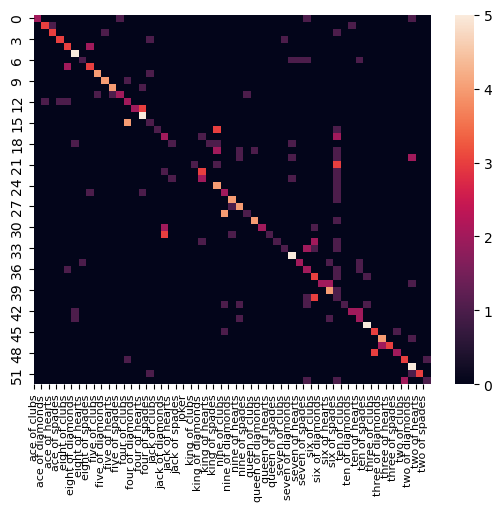

In [4]:
acc_metric = MulticlassAccuracy(device="cuda", num_classes=53)
confusion_matrix = MulticlassConfusionMatrix(device='cuda', num_classes=53)
f1_score = MulticlassF1Score(device='cuda', num_classes=53)
epochs = 1
# number of batches between metric computations
compute_frequency = 2
for epoch in range(epochs):
    valid_iter = iter(valid_loader)
    t = time.time()
    model.eval()

    for i in range(len(valid_loader)):
        batch_cpu = next(valid_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        B,_,_,_ = batch_gpu['image'].shape
        adjs = [adj.detach().clone() for i in range(B)]
        ADJ = torch.block_diag(*adjs)
        ADJ = ADJ.to("cuda")

        pred = model(batch_gpu['image'], ADJ)
        # metric.update() updates the metric state with new data
        target = batch_gpu['label']
        acc_metric.update(pred, target)
        confusion_matrix.update(pred, target)
        f1_score.update(pred, target)
    print(
        "Epoch {}/{}, Batch {}/{} --- acc: {:.4f}".format(
            epoch + 1,
            epochs,
            i + 1,
            len(valid_loader),
            # metric.compute() returns metric value from all seen data
            acc_metric.compute(),
        )
    )
    print(f1_score.compute())
    ax = sns.heatmap(confusion_matrix.compute().cpu(), linecolor='white')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, size=8)
    fig = ax.get_figure()
    fig.savefig("confusion_matrix.png")
    # metric.reset() reset metric states. It's typically called after the epoch completes.